# Seatle Airbnb Dataset

### In this notebook we will use the Seattle Airbnb dataset to answer the following questions:

1. What is the average nightly rate for different types of Airbnb listings in Seattle, and how does this vary by neighborhood?

2. Are there certain amenities that are associated with higher-rated Airbnb listings in Seattle, and if so, what are they?

3. What are the features that influence a listing's rating?

4. How well can we predict the price of a listing, given its size (e.g. number of bedrooms, bathrooms, etc.) ?

In [114]:
# importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import re
%matplotlib inline

In [115]:
#read in the dataset
data = pd.read_csv('./archive/listings.csv')
print(data.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [116]:
data.columns[data.isnull().any()]

Index(['summary', 'space', 'neighborhood_overview', 'notes', 'transit',
       'thumbnail_url', 'medium_url', 'xl_picture_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'zipcode', 'property_type', 'bathrooms', 'bedrooms', 'beds',
       'square_feet', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'license',
       'reviews_per_month'],
      dtype='object')

## Question 1
#### What is the average nightly rate for different types of Airbnb listings in Seattle, and how does this vary by neighbourhood?

#### First, we need to know the number of missing values

In [117]:
def missing_values(df,col):
    total_count = np.sum(df[f'{col}'].isna())
    return (total_count , total_count / len(df[f'{col}']))

In [118]:
def remove_missing_rows(df,cols):
    '''
    Remove Rows that have NA in the given list of columns and having only those columns
    '''
    df = df.loc[:,cols]
    return df.dropna(subset = cols, how='any')

In [119]:
print(f"Number of missing values in, Property type : {missing_values(data,'property_type')[0]}"
        f", Price : {missing_values(data,'price')[0]}, Neighbourhood : {missing_values(data,'neighbourhood')[0]}")

Number of missing values in, Property type : 1, Price : 0, Neighbourhood : 416


As we can see the number of missing values are relatively low. In addition to that, the neighbourhood is fundamental in our analysis, so having missing values in the neghbourhood is irrelevant

In [120]:
q1_df = remove_missing_rows(data,['price','neighbourhood','property_type'])
q1_df.head()

,price,neighbourhood,property_type
0,$85.00,Queen Anne,Apartment
1,$150.00,Queen Anne,Apartment
2,$975.00,Queen Anne,House
3,$100.00,Queen Anne,Apartment
4,$450.00,Queen Anne,House


In [121]:
def price_string_to_int(df,col,dropna = False):
    if dropna:
        df[f'{col}']=pd.to_numeric(df[f'{col}'].str[1:],errors='coerce').dropna()
    else:
        df[f'{col}']=pd.to_numeric(df[f'{col}'].str[1:],errors='coerce')
    return df
def one_hot_encode(df,col):
    '''
    Given a column 1 hot encode the values and remove the original
    '''
    df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
    return df

In [122]:
# change the price from string to int
q1_df = price_string_to_int(q1_df,'price')
q1_df.head()

,price,neighbourhood,property_type
0,85.0,Queen Anne,Apartment
1,150.0,Queen Anne,Apartment
2,975.0,Queen Anne,House
3,100.0,Queen Anne,Apartment
4,450.0,Queen Anne,House


In [123]:
# get the avg of each property type across Seattle
q1_df1 = q1_df.groupby(['property_type'])['price'].aggregate(['min','mean','max']).sort_values(by='mean',ascending=False)
q1_df1.head()

,min,mean,max
property_type,,,
Boat,75.0,221.666667,775.0
Condominium,50.0,155.698795,700.0
Loft,49.0,135.970588,425.0
Townhouse,33.0,134.254717,498.0
House,25.0,132.673312,975.0


In [124]:
q1_df = q1_df.groupby(['property_type', 'neighbourhood'])['price'].aggregate(['min','mean','max']).sort_values(by='mean',ascending=False)
q1_df.head()

min        mean    max
property_type neighbourhood                                
Boat          Westlake             150.0  462.500000  775.0
House         Fairmount Park       370.0  370.000000  370.0
              Portage Bay           90.0  340.285714  750.0
Townhouse     Green Lake           325.0  325.000000  325.0
Loft          Industrial District  320.0  320.000000  320.0

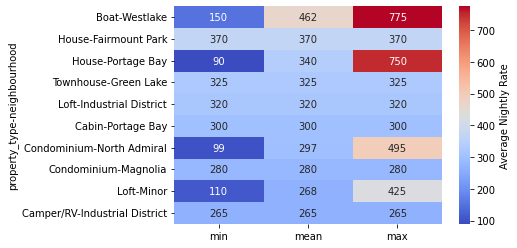

In [125]:
sns.heatmap(q1_df[:10],cmap='coolwarm', annot=True, fmt='.0f',cbar_kws={'label': 'Average Nightly Rate'});

### Conslusion
As we can see the average nightly rate varies greatly by neighbourhood, this states the fact that, in certain neighbourhoods you some property types are more popular than other neighbourhoods within Seattle.

## Question 2
#### Are there certain amenities that are associated with higher-rated Airbnb listings in Seattle, and if so, what are they?

In [126]:
# get the number or missing values in the dataset
q2_df = data[['amenities','review_scores_rating']]
q2_df.head()

,amenities,review_scores_rating
0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",95.0
1,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",96.0
2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",97.0
3,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",NaN
4,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",92.0


In [127]:
print(f"The missing values in Amenities = {missing_values(q2_df,'amenities')[0]} , {missing_values(q2_df,'amenities')[1]}%"
     f"\nThe missing Ratings = {missing_values(q2_df,'review_scores_rating')[0]} , {missing_values(q2_df,'review_scores_rating')[1]}%")

The missing values in Amenities = 0 , 0.0%
The missing Ratings = 647 , 0.16946045049764275%


#### Why is this data missing?
That might be because no one has yet to try those listings, so having them in our analysis is irrelevant.

In [128]:
# remove the rows with missing ratings
q2_df = remove_missing_rows(q2_df,['amenities','review_scores_rating'])
# print(re.split(",|{|}",q2_df['amenities'][1][1:-1]))
print(re.sub("[{|}]","",q2_df['amenities'][1][1:-1]))

TV,Internet,"Wireless Internet",Kitchen,"Free Parking on Premises","Buzzer/Wireless Intercom",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","First Aid Kit","Safety Card","Fire Extinguisher",Essentials


In [129]:
def split_amenities(val):
#     return re.split(",|{|}",val[1:-1])
    return re.sub("[{|}]","",val) if val else None
def remove_quotes(lst):
    return "".join([s.replace('"', '') for s in lst]) if lst else None
q2_df['amenities'] = q2_df['amenities'].apply(lambda x : split_amenities(x))
q2_df['amenities'] = q2_df['amenities'].apply(remove_quotes)

q2_df.head()

,amenities,review_scores_rating
0,"TV,Cable TV,Internet,Wireless Internet,Air Con...",95.0
1,"TV,Internet,Wireless Internet,Kitchen,Free Par...",96.0
2,"TV,Cable TV,Internet,Wireless Internet,Air Con...",97.0
4,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",92.0
5,"Wireless Internet,Free Parking on Premises,Hea...",95.0


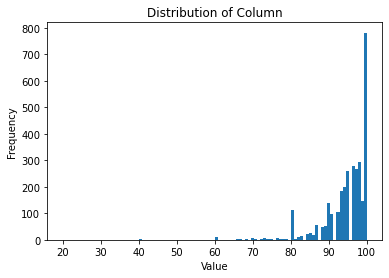

In [130]:
plt.hist(q2_df['review_scores_rating'],bins = 100)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Column')
plt.show()

In [131]:
# split into 2 groups, average rating listings and higher than average listings
average_rating = q2_df['review_scores_rating'].mean()
q2_df['rating_group'] = q2_df['review_scores_rating'].apply(lambda x: 'High' if x > average_rating else 'Average')
high_rated_df = q2_df[q2_df['rating_group'] == 'High']
average_rated_df = q2_df[q2_df['rating_group'] == 'Average']

In [132]:
high_rated_amenities = set(high_rated_df['amenities'].str.cat(sep=',').split(','))
average_rated_amenities = set(average_rated_df['amenities'].str.cat(sep=',').split(','))
high_rated_only_amenities =  high_rated_amenities - average_rated_amenities
average_rated_only_amenities =  average_rated_amenities-high_rated_amenities
print(average_rated_only_amenities)
print(high_rated_only_amenities)

{'Washer / Dryer'}
set()


### Conclusion
As we can see from the results above, average-rated amenities and high-rated amenities have almost the exact same set of amenities. So we can conclude that the amenities available in listings are not related to the rating of the listing.

## Question 3
#### What are the features that influence a listing's rating?

In [133]:
# first remove rows that have no ratings
q3_df = data.dropna(subset=['review_scores_rating'])
# remove unnecessary columns
q3_df = q3_df[['host_response_rate', 'host_is_superhost','host_verifications', 'host_identity_verified', 'neighbourhood',
                'property_type', 'accommodates', 'price','security_deposit','cleaning_fee', 'guests_included', 'extra_people','availability_30', 'availability_60', 'availability_90',
               'availability_365', 'number_of_reviews','review_scores_rating', 'instant_bookable']]
q3_df.head()

,host_response_rate,host_is_superhost,host_verifications,host_identity_verified,neighbourhood,property_type,accommodates,price,security_deposit,cleaning_fee,guests_included,extra_people,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,instant_bookable
0,96%,f,"['email', 'phone', 'reviews', 'kba']",t,Queen Anne,Apartment,4,$85.00,NaN,NaN,2,$5.00,14,41,71,346,207,95.0,f
1,98%,t,"['email', 'phone', 'facebook', 'linkedin', 're...",t,Queen Anne,Apartment,4,$150.00,$100.00,$40.00,1,$0.00,13,13,16,291,43,96.0,f
2,67%,f,"['email', 'phone', 'google', 'reviews', 'jumio']",t,Queen Anne,House,11,$975.00,"$1,000.00",$300.00,10,$25.00,1,6,17,220,20,97.0,f
4,100%,f,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,Queen Anne,House,6,$450.00,$700.00,$125.00,6,$15.00,30,60,90,365,38,92.0,f
5,NaN,f,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,Queen Anne,House,2,$120.00,NaN,$40.00,1,$30.00,0,0,27,302,17,95.0,f


In [134]:
q3_df.isnull().sum()

host_response_rate         312
host_is_superhost            0
host_verifications           0
host_identity_verified       0
neighbourhood              305
property_type                0
accommodates                 0
price                        0
security_deposit          1561
cleaning_fee               759
guests_included              0
extra_people                 0
availability_30              0
availability_60              0
availability_90              0
availability_365             0
number_of_reviews            0
review_scores_rating         0
instant_bookable             0
dtype: int64

Why is this data missing ?

1) host_response_rate: must be because this host is new to the platform and didn't yet have any messages. So we will assume that his rate is 0% .

2) neighbourhood: those who didn't mention the neighbourhood must've forgot to do so, accordingly we will impute with 'no_neighbourhood' to see it it matters to mention the neighbourhood or not.

3) bathrooms: we will impute with the average number of bathrooms within the dataset as hosts might have forgotten to put them.

4) security_deposit, cleaning_fee: Those values might be missing because they neither have a security deposit nor a cleaning fee, so we will impute with zeros

In [135]:
def encode_value(val):
    return 1 if val=='t'else 0
def percentage_to_int(percentage):
    return int(percentage.replace("%",""))

In [136]:
#impute the missing values
q3_df['host_response_rate'].fillna('0%',inplace=True)
q3_df['neighbourhood'].fillna('no_neighbourhood',inplace=True)
# q3_df['bathrooms'].fillna(q3_df['bathrooms'].mean() //1 , inplace =True)
q3_df['security_deposit'].fillna('$0',inplace=True)
q3_df['cleaning_fee'].fillna('$0',inplace=True)
q3_df.head()

,host_response_rate,host_is_superhost,host_verifications,host_identity_verified,neighbourhood,property_type,accommodates,price,security_deposit,cleaning_fee,guests_included,extra_people,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,instant_bookable
0,96%,f,"['email', 'phone', 'reviews', 'kba']",t,Queen Anne,Apartment,4,$85.00,$0,$0,2,$5.00,14,41,71,346,207,95.0,f
1,98%,t,"['email', 'phone', 'facebook', 'linkedin', 're...",t,Queen Anne,Apartment,4,$150.00,$100.00,$40.00,1,$0.00,13,13,16,291,43,96.0,f
2,67%,f,"['email', 'phone', 'google', 'reviews', 'jumio']",t,Queen Anne,House,11,$975.00,"$1,000.00",$300.00,10,$25.00,1,6,17,220,20,97.0,f
4,100%,f,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,Queen Anne,House,6,$450.00,$700.00,$125.00,6,$15.00,30,60,90,365,38,92.0,f
5,0%,f,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,Queen Anne,House,2,$120.00,$0,$40.00,1,$30.00,0,0,27,302,17,95.0,f


In [137]:
q3_df['host_response_rate']=q3_df['host_response_rate'].apply(percentage_to_int)
q3_df['host_is_superhost']=q3_df['host_is_superhost'].apply(encode_value)
q3_df['host_identity_verified']=q3_df['host_identity_verified'].apply(encode_value)
q3_df['instant_bookable']=q3_df['instant_bookable'].apply(encode_value)
q3_df = price_string_to_int(q3_df,'cleaning_fee')
q3_df = price_string_to_int(q3_df,'extra_people')
q3_df = price_string_to_int(q3_df,'price')
q3_df = price_string_to_int(q3_df,'security_deposit')
q3_df['host_verifications'] = q3_df['host_verifications'].apply(lambda x : x[1:-1].replace("'","").split(", "))
# q3_df = one_hot_encode(q3_df , 'host_verifications')
q3_df = pd.concat([q3_df.drop('host_verifications',axis=1),q3_df['host_verifications'].apply(pd.Series).stack().str.get_dummies().sum(level=0)])
q3_df = q3_df.fillna(value=0)
q3_df = one_hot_encode(q3_df , 'neighbourhood')
q3_df = one_hot_encode(q3_df , 'property_type')
# q3_df = one_hot_encode(q3_df , 'bed_type')
# q3_df['amenities'] = q3_df['amenities'].apply(lambda x : split_amenities(x))
# q3_df['amenities'] = q3_df['amenities'].apply(remove_quotes)
# q3_df['amenities'] = q3_df['amenities'].apply(lambda x : list(x.split(","))if x else None)
# q3_df = pd.concat([q3_df.drop('amenities',axis=1),q3_df['amenities'].apply(pd.Series).stack().str.get_dummies().sum(level=0)])
q3_df = q3_df.fillna(value=0)

# q3_df['extra_people']=q3_df['extra_people'].apply(price_string_to_int)
# q3_df['price']=q3_df['price'].apply(price_string_to_int)
# q3_df['security_deposit']=q3_df['security_deposit'].apply(price_string_to_int)



q3_df.head()

/tmp/ipykernel_10567/1738664459.py:11: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  q3_df = pd.concat([q3_df.drop('host_verifications',axis=1),q3_df['host_verifications'].apply(pd.Series).stack().str.get_dummies().sum(level=0)])


,host_response_rate,host_is_superhost,host_identity_verified,accommodates,price,security_deposit,cleaning_fee,guests_included,extra_people,availability_30,...,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt
0,96.0,0.0,1.0,4.0,85.0,0.0,0.0,2.0,5.0,14.0,...,0,0,0,0,0,0,0,0,0,0
1,98.0,1.0,1.0,4.0,150.0,100.0,40.0,1.0,0.0,13.0,...,0,0,0,0,0,0,0,0,0,0
2,67.0,0.0,1.0,11.0,975.0,0.0,300.0,10.0,25.0,1.0,...,0,0,0,1,0,0,0,0,0,0
4,100.0,0.0,1.0,6.0,450.0,700.0,125.0,6.0,15.0,30.0,...,0,0,0,1,0,0,0,0,0,0
5,0.0,0.0,1.0,2.0,120.0,0.0,40.0,1.0,30.0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [138]:
# q3_df['host_verifications'][0][1:-1].replace("'","").split(", ")

In [139]:
q3_df.dtypes

host_response_rate         float64
host_is_superhost          float64
host_identity_verified     float64
accommodates               float64
price                      float64
                            ...   
property_type_Other          uint8
property_type_Tent           uint8
property_type_Townhouse      uint8
property_type_Treehouse      uint8
property_type_Yurt           uint8
Length: 126, dtype: object

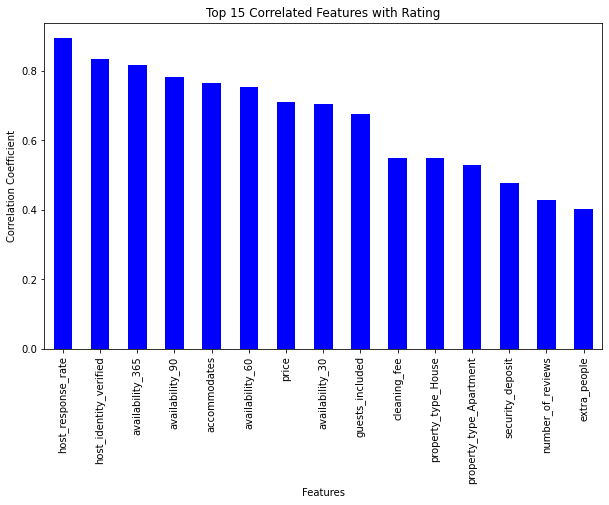

In [140]:
# get the correlation between all columns and the reviews
corr_matrix = q3_df.corrwith(q3_df['review_scores_rating']).sort_values(ascending=False)

# Visualize the top 15 correlated values and the reviews
top_15_corr = corr_matrix[1:16]  # Excluding the 'review_scores_rating' column
top_15_corr.plot(kind='bar', figsize=(10, 6), color='blue')
plt.title('Top 15 Correlated Features with Rating')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.show()

### Conclusion
As we can see from the results above, the highest correlated variable to the review of a given listing is a given host's response rate. As clarified in the plot above showing the top 15 correlated variables with the rating of a given listing.

## Question 4
#### How well can we predict the price of a listing, given its size (e.g. number of bedrooms, bathrooms, etc.) ?

In [141]:
q4_df = data[['bathrooms', 'bedrooms', 'beds', 'square_feet',
       'price']]

q4_df.head()


,bathrooms,bedrooms,beds,square_feet,price
0,1.0,1.0,1.0,NaN,$85.00
1,1.0,1.0,1.0,NaN,$150.00
2,4.5,5.0,7.0,NaN,$975.00
3,1.0,0.0,2.0,NaN,$100.00
4,2.0,3.0,3.0,NaN,$450.00


In [142]:
print(
     
     f"\nThe missing values in bathrooms = {missing_values(q4_df,'bathrooms')[0]} , {missing_values(q4_df,'bathrooms')[1]}%"
     f"\nThe missing values in bedrooms = {missing_values(q4_df,'bedrooms')[0]} , {missing_values(q4_df,'bedrooms')[1]}%"
     f"\nThe missing values in beds = {missing_values(q4_df,'beds')[0]} , {missing_values(q4_df,'beds')[1]}%"
     f"\nThe missing values in square_feet = {missing_values(q4_df,'square_feet')[0]} , {missing_values(q4_df,'square_feet')[1]}%"
     f"\nThe missing values in price = {missing_values(q4_df,'price')[0]} , {missing_values(q4_df,'price')[1]}%")


The missing values in bathrooms = 16 , 0.0041906757464641176%
The missing values in bedrooms = 6 , 0.001571503404924044%
The missing values in beds = 1 , 0.00026191723415400735%
The missing values in square_feet = 3721 , 0.9745940282870613%
The missing values in price = 0 , 0.0%


As we can see, almost all rows are filled, so we can safely drop rows that have no property_type, bathrooms, bedrooms as the hosts of these listings might have forgot to add them. As for the square_feet column we can completely drop it as the hosts might not know the exact number to put in, and the size is usually implied by the number of rooms in the property.

In [143]:
q4_df.drop('square_feet',axis=1,inplace=True)
q4_df = remove_missing_rows(q4_df,['bathrooms', 'bedrooms', 'beds', 
       'price'])
q4_df.head()

/home/ishams/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,bathrooms,bedrooms,beds,price
0,1.0,1.0,1.0,$85.00
1,1.0,1.0,1.0,$150.00
2,4.5,5.0,7.0,$975.00
3,1.0,0.0,2.0,$100.00
4,2.0,3.0,3.0,$450.00


In [144]:
q4_df.dtypes

bathrooms    float64
bedrooms     float64
beds         float64
price         object
dtype: object

In [145]:
# change price to float
q4_df = price_string_to_int(q4_df,'price')
q4_df = q4_df.dropna(axis=0, subset=['price'])
q4_df.head()

,bathrooms,bedrooms,beds,price
0,1.0,1.0,1.0,85.0
1,1.0,1.0,1.0,150.0
2,4.5,5.0,7.0,975.0
3,1.0,0.0,2.0,100.0
4,2.0,3.0,3.0,450.0


In [146]:
X,y = q4_df.drop('price',axis=1),q4_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 

#Rsquared and y_test
rsquared_score = r2_score(y_test, y_test_preds)
length_y_test = len(y_test)

"The r-squared score for your model was {} on {} values.".format(rsquared_score, length_y_test)

'The r-squared score for your model was 0.45956146633675177 on 1139 values.'

### Conclusion
As we can see from the results above, the r-squared score is about 0.45, which means that the independent variables (in this case 'bathrooms', 'bedrooms', 'beds'), the size of a listing is not actually sufficient to predict the price of that listing.